# Data Cleaning

In [2]:
import numpy as np
import pandas as pd
import json
import os
import string
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data_dir="./Linkedin"
profiles_path = os.path.join(data_dir, 'linkedin(missing).json')
print(os.listdir(data_dir))

['linkedin.json', '.ipynb_checkpoints', 'linkedin(missing).json']


In [4]:
#function that remove punctuation from strings
def remove_punctuation(s):
    translator = str.maketrans('', '', string.punctuation) 
    return s.translate(translator)

In [5]:
#read JSON
num_profiles_from_JSON = 100000
profiles = []

for line in open(profiles_path):
    if len(profiles) < num_profiles_from_JSON:
        line = json.loads(line)
        profiles.append(line)
        
    else:
        break

print('Number of profiles loaded from JSON:', len(profiles))

Number of profiles loaded from JSON: 100000


            if 'education' in i:
                education_is_english = True
                for m in range(len(i['education'])):
                    word_list = remove_punctuation(i['education'][m]['name']).lower().split()
                    for k in word_list:
                        if not wordnet.synsets(k):
                            education_is_english = False
                            break
                    if education_is_english == False:
                        break
            else:
                education_is_english = True

In [6]:
import nltk
from nltk.corpus import wordnet
import random

#extract features from list of dictionaries and put into a dataframe
feature_extraction_list = ['skills','specilities','interests','experience','education','summary','honors','industry','group']
df = pd.DataFrame(columns=feature_extraction_list)
rows_list = []

#parameters for checking English
number_of_word_to_test = 20 #number of random words picked from 'experience' to check for English
non_eng_threshold = 0.25 #the percentage of non-english words allowed during checking before removing a profile
            

print('Checking language...')
num_profiles_with_features = 0
num_profiles_lang_not_en = 0
for i in profiles: 
    if ("experience" in i) and ("education" in i) and ("skills" in i):
        num_profiles_with_features = num_profiles_with_features + 1

        if 'industry' in i:
            industry_is_english = True
            word_list = remove_punctuation(str(i['industry'])).lower().split()
            for k in word_list:
                if not wordnet.synsets(k):
                    industry_is_english = False
        else:
            industry_is_english = True

        if industry_is_english == True:
            word_list = remove_punctuation(str(i['experience'])).lower().split()
            word_list_rand = []
            for k in range(number_of_word_to_test):
                word_list_rand.append(word_list[random.randrange(1, len(word_list))])
            eng_count = 0
            for k in word_list_rand:
                if wordnet.synsets(k):
                    eng_count = eng_count + 1           
            if eng_count/len(word_list_rand) >= (1 - non_eng_threshold):
                is_english = True
            else:
                is_english = False
        else: 
            is_english = False

        if is_english == True:            
            dict1 = {}
            for j in feature_extraction_list:
                if j in i:
                    dict1[j] = i[j]
                else:
                    if j in ['specilities','interests','summary','industry']:
                        dict1[j] = ''
                    elif j in ['skills','honors','group']:
                        dict1[j] = []
                    else:
                        dict1[j] = float('nan')            
            rows_list.append(dict1)
        else:
            num_profiles_lang_not_en = num_profiles_lang_not_en + 1

df = pd.DataFrame(rows_list)
print('Number of profiles with experience, education, and skills:', num_profiles_with_features)
print('Number of profiles removed because it is not in english:', num_profiles_lang_not_en)
print('Percentage of profiles removed because it is not in english: ', round(num_profiles_lang_not_en/num_profiles_with_features*100, 2),'%', sep='')
print('Number of profiles loaded into the dataFrame:', len(rows_list))


Checking language...
Number of profiles with experience, education, and skills: 58827
Number of profiles removed because it is not in english: 45249
Percentage of profiles removed because it is not in english: 76.92%
Number of profiles loaded into the dataFrame: 13578


In [7]:
#loop through df to fill in the following columns
df['occupation'] = ''
df['company'] = ''
df['major'] = ''
df['institution'] = ''
df['degree'] = ''

for index, row in df.iterrows():
    if type(row["experience"]) == list:
        temp_occupation = []
        temp_company = []
        for i in row['experience']:
            if 'title' in i:
                temp_occupation.append(i['title'])
            else:
                temp_occupation.append('')
            if 'org' in i:
                temp_company.append(i['org'])
            else:
                temp_company.append('')        
        if len(temp_occupation) == 0:
            row['occupation'] = []
        else:
            row['occupation'] = temp_occupation
        if len(temp_company) == 0:
            row['company'] = []
        else:
            row['company'] = temp_company
    
    if type(row["education"]) == list:
        temp_institution = []
        temp_major = []
        temp_degree = []
        for i in row['education']:
            if 'name' in i:
                temp_institution.append(i['name'])
            else:
                temp_institution.append('')
            if 'major' in i:
                temp_major.append(i['major'])
            else:
                temp_major.append('')              
            if 'degree' in i:
                temp_degree.append(i['degree'])
            else:
                temp_degree.append('') 
                
        if len(temp_institution) == 0:
            row['institution'] = []
        else:
            row['institution'] = temp_institution
        if len(temp_major) == 0:
            row['major'] = []
        else:
            row['major'] = temp_major
        if len(temp_degree) == 0:
            row['degree'] = []
        else:
            row['degree'] = temp_degree            
                
    if (type(row['group']) == dict and 'affiliation' in row['group']):
        row['group'] = row['group']['affiliation']
    else:
        row['group'] = []
        
    if row['occupation'] == '':
        row['occupation'] = []
    if row['company'] == '':
        row['company'] = []
    if row['major'] == '':
        row['major'] = []
    if row['institution'] == '':
        row['institution'] = []

In [8]:
#manually standardize degrees
for index, row in df.iterrows():
    if type(row['degree']) == list:
        temp_degree = []
        for degree in row['degree']:
            degree = remove_punctuation(degree.upper())

            if 'PHD' in degree:
                degree = 'PHD'
            if "POST GRADUATE" in degree:
                degree = "POST GRADUATE"
            if "MASTER OF SCIENCE" in degree or 'MSC' in degree or 'MS' in degree:
                degree = 'MS'
            if "MASTERS" in degree or "MASTER" in degree:
                degree = 'MASTER'
            if 'MBA' in degree:
                degree = 'MBA'
            if "BACHELOR OF SCIENCE" in degree or "BSC" in degree or "BS" in degree:
                degree = 'BS'
            if "BACHELOR OF ARTS" in degree or "BA" in degree:
                degree = 'BA'
            if "BACHELORS" in degree or "BACHELOR" in degree:
                degree = 'BACHELOR'
            if 'ASSOCIATE' in degree:
                degree = 'ASSOCIATE'
            if 'SCIENCE' in degree:
                degree = 'SCIENCE'
            if 'ENGINEERING' in degree or 'ENGINEER' in degree:
                degree = 'ENGINEERING'
            if 'BUSINESS' in degree:
                degree = 'BUSINESS'
            if "MANAGEMENT" in degree:
                degree = "MANAGEMENT"
            if 'RESEARCH' in degree:
                degree = 'RESEARCH'
            if 'HIGH' in degree or 'SECONDARY' in degree:
                degree = 'HIGH'
            useless_list = ['CERTIFICATE', 'CERTIFICATION', 'CERTIFIED', 'COURSE', 'DE', 'DEGREE', 'DIPLOMA', 'LEVELS', 'LICENCE', 'PROGRAM', 'SCHOOL']
            for i in useless_list:
                if i in degree:
                    degree = ""
            
            temp_degree.append(degree)
        if len(temp_degree) == 0:
            row['degree'] = []
        else:
            row['degree'] = temp_degree

In [9]:
#calculating year of work experience based on the year of data collection and the year of graduation for bachelor degree

year_of_data_collection = 2019

df['year_of_work_experience'] = ''
for index, row in df.iterrows():
    year_min = year_of_data_collection
    if type(row['degree']) == list:
        for i in range(0,len(row['degree'])):
            if row['degree'][i] == 'HIGH':
                break
            if 'end' in row['education'][i]:
                try:
                    year_temp = parser.parse(row['education'][i]['end']).year
                except:
                    pass
                    
                if year_temp < year_min:
                    year_min = year_temp
                
    if type(row['experience']) == list:
        for i in range(0,len(row['experience'])):
            if 'start' in row['experience'][i]:
                try:
                    year_temp = parser.parse(row['experience'][i]['start']).year
                except:
                    pass
                
                if year_temp < year_min:
                    year_min = year_temp                
        
    row['year_of_work_experience'] = year_of_data_collection - year_min       

    if row['year_of_work_experience'] == '':
        row['year_of_work_experience'] = float('nan')

In [10]:
df = df[['skills','specilities','interests',
               'institution','degree','major',
               'summary','honors','industry',
               'occupation','company',
               'year_of_work_experience','group']].copy()

df.head()

,skills,specilities,interests,institution,degree,major,summary,honors,industry,occupation,company,year_of_work_experience,group
0,"[DNA, Nanotechnology, Molecular Biology, Softw...",,"personal genomics, nanotechnology","[Harvard University, Yale University]","[PHD, BS]","[Biophysics, Computer Science]",I am interested in inventing new methods to co...,[],Research,"[Assistant Professor, Technology Development F...","[UCSF, Wyss Institute for Biologically Inspire...",16,[]
1,"[AML, Relationship Management, Team Management...",,"Training & Organizational development, strateg...","[University of Mumbai, Indian Institute of Fin...","[MAM, MBF, BS]","[Human Resources, Finance, Chemistry]",SYNOPSISMeticulous and highly networked & acco...,[],Banking,"[Director - Transaction Banking, Head Channel ...","[Standard Chartered Bank, ICICI Bank, J K HELE...",33,[]
2,"[Primavera, Revit MEP, AutoCAD, Engineering, H...",,"Project Management, Innovative Designs, New Te...","[University of Petroleum & Energy Studies, IIT...","[, , , , ]","[, , , , ]",More than 08 yrs of experience with hands on e...,[# Selected in ARMY through SSB (Technical Gra...,Oil & Energy,[Manager (International Business Development &...,"[VOITH Hydro Pvt Ltd., VOITH Hydro Pvt. Ltd., ...",22,[]
3,"[Brand Management, Integrated Marketing, Telev...",,"Broadcast Design, Television, Creativity, Music.",[Instituto de Diseño de Caracas],[],[],Accomplished Chief Creative Officer with 15+ y...,"[Promax and BDA World Gold Awards, New York Fe...",Broadcast Media,"[Creative Services, Vice President, Creative S...","[Discovery Communications, Warner Channel, War...",28,[]
4,"[E-Learning, Instructional Design]",,,"[Capella University, The University of Texas a...","[PHD, MASTER, HIGH]",[Education (Training & Performance Improvement...,Performance Technology StewardStrengths (as ma...,[],Education Management,"[Global Training Development Manager, GE Oil &...","[GE Energy, Human Development & Consumer Scien...",18,[]


In [11]:
print('Percentage of profiles with value for work years:', 
      df['year_of_work_experience'].count()/df.shape[0]*100,
      '%')

Percentage of profiles with value for work years: 100.0 %


# Word to Vec

In [12]:
from gensim.models import KeyedVectors
import re
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
import unicodedata
import nltk
#import contractions
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [13]:
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/rmeng4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
def remove_stopwords(words):
    stopword_list = stopwords.words('english') + stopwords.words('french') + stopwords.words('german') + stopwords.words('spanish') + stopwords.words('russian')
    for word in words:
        if word in stopword_list:
            words.remove(word)
    return words

In [15]:
lemmatizer = WordNetLemmatizer()

occupation = list()
for index,row in df.iterrows():
    r = list()
    for i in row['occupation']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=lemmatizer.lemmatize(i,pos='n')
        i=nltk.word_tokenize(i)
        i=remove_stopwords(i)
        r.append(i)
    occupation.append(r)

#print(occupation)

In [16]:
all_sentences = []
for text in occupation:
    all_sentences += text

phrases = Phrases(all_sentences, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences = list(bigram[all_sentences])

model1 = Word2Vec(all_sentences, 
                 min_count=20,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [17]:
skills = list()
for index,row in df.iterrows():
    r = list()
    for i in row['skills']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=lemmatizer.lemmatize(i,pos='n')
        i=nltk.word_tokenize(i)
        i=remove_stopwords(i)
        r.append(i)
    skills.append(r)
    
#print(skills)

In [18]:
all_sentences2 = []
for text in skills:
    all_sentences2 += text
    
phrases = Phrases(all_sentences2, min_count=1, threshold=1)
bigram=Phraser(phrases)
all_sentences2 = list(bigram[all_sentences2])

model2 = Word2Vec(all_sentences2, 
                 min_count=50,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [19]:
major = list()
for index,row in df.iterrows():
    r = list()
    for i in row['major']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=lemmatizer.lemmatize(i,pos='n')
        i=nltk.word_tokenize(i)
        i=remove_stopwords(i)
        r.append(i)
    major.append(r)
    
#print(major)

In [20]:
all_sentences3 = []
for text in major:
    all_sentences3 += text
    
phrases = Phrases(all_sentences3, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences3 = list(bigram[all_sentences3])

model3 = Word2Vec(all_sentences3, 
                 min_count=200,   # Ignore words that appear less than this
                 size=100,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [21]:
degree = list()
for index,row in df.iterrows():
    r = list()
    for i in row['degree']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        #i=lemmatizer.lemmatize(i,pos='n')
        i=nltk.word_tokenize(i)
        i=remove_stopwords(i)
        r.append(i)
    degree.append(r)
    
#print(degree)

In [22]:
all_sentences4 = []
for text in degree:
    all_sentences4 += text
    
phrases = Phrases(all_sentences4, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences4 = list(bigram[all_sentences4])

model4 = Word2Vec(all_sentences4, 
                 min_count=200,   # Ignore words that appear less than this
                 size=50,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [23]:
def remove_institution(words):
    institution_list = ['university', 'college', 'school', 'institute', 'academy', 'université', 'collège', 'école', 'institut', 'académie', 'universität', 'hochschule', 'kolleg', 'schule', 'akademie', 'universidad', 'colegio', 'escuela', 'instituto', 'academia', 'университет', 'колледж', 'школа', 'институт', 'академия']
    for word in words:
        if word in institution_list:
            words.remove(word)
    return words

In [24]:
institution = list()
for index,row in df.iterrows():
    r = list()
    for i in row['institution']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=lemmatizer.lemmatize(i,pos='n')
        #i=nltk.word_tokenize(i)
        #i=remove_stopwords(i)
        #i=remove_institution(i)
        r.append(i)
    institution.append(r)
    
#print(institution)

In [25]:
all_sentences5 = []
for text in institution:
    all_sentences5 += text
    
phrases = Phrases(all_sentences5, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences5 = list(bigram[all_sentences5])

model5 = Word2Vec(all_sentences5, 
                 min_count=50,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [26]:
industry = list()
for i in df['industry']:
    r = list()
    if type(i) == float:
        i = ""
    i=i.translate(str.maketrans('', '', string.punctuation))
    i=i.lower()
    i=lemmatizer.lemmatize(i,pos='n')
    i=nltk.word_tokenize(i)
    i=remove_stopwords(i)
    r.append(i)
    industry.append(r)
#print(industry)

In [27]:
all_sentences6 = []
for text in industry:
    all_sentences6 += text
    
phrases = Phrases(all_sentences6, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences6 = list(bigram[all_sentences6])

model6 = Word2Vec(all_sentences6, 
                 min_count=50,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=2,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [28]:
print(len(model1.wv.vocab)) # occupation
print(len(model2.wv.vocab)) # skill
print(len(model3.wv.vocab)) # major (done)
print(len(model4.wv.vocab)) # degree (done, no clustering)
print(len(model5.wv.vocab)) # institution
print(len(model6.wv.vocab)) # industry (done)

913
742
26
7
54
75


In [29]:
print(model1.wv.vocab.keys())

dict_keys(['assistant_professor', 'technology', 'development', 'fellow', 'director', 'head', 'channel', 'india', 'sales_manager', 'division', 'product', 'engineer', 'manager', 'international_business', 'marketing', 'engineering', 'group', 'sr', 'creative_services', 'vice_president', 'art_director', 'creative_director', 'owner', 'professor', 'graphic_design', 'global', 'training_development', 'oil_gas', 'adjunct_faculty', 'phd_candidate', 'program', 'ii', 'training_specialist', 'assistant', 'operations', 'front_desk', 'clerk', 'library', 'strategy', 'design', 'artist', 'consultant', 'partner', 'business_development', 'executive', 'career', 'key_account', 'business', 'design_intern', 'designer', 'production', 'change', 'architect', 'dev', 'specialist', 'application_development', 'analyst', 'test_engineer', 'a', 'billing', 'administrator', 'human_resources', 'director_human', 'resources', 'area', 'regional', 'representative', 'coordinator', 'generalist', 'technical_support', 'senior', 'op

# Hierarchical Clustering

In [49]:
from sklearn.cluster import AgglomerativeClustering
n_clusters = 10
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

model3vec_list = list()
for i in list(model3.wv.vocab.keys()):
    model3vec_list.append(model3[i])
model3vec_cluster = list(cluster.fit_predict(model3vec_list))

model3vec = dict()
for i in range(len(model3.wv.vocab.keys())):
    model3vec[list(model3.wv.vocab.keys())[i]] = model3vec_cluster[i]
print(model3vec)
print('\n')
model3_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in model3vec.items() if v == i])
    model3_cluster_list.append([k for k,v in model3vec.items() if v == i])
    print('\n')

{'computer_science': 5, 'human_resources': 3, 'finance': 2, 'psychology': 3, 'design': 5, 'communication': 1, 'science': 2, 'political_science': 7, 'english': 1, 'management': 6, 'business': 0, 'economics': 2, 'accounting': 1, 'marketing': 5, 'engineering': 0, 'business_administration': 1, 'computer': 9, 'studies': 5, 'technology': 8, 'mechanical_engineering': 4, 'mathematics': 1, 'information_systems': 5, 'electrical_engineering': 4, 'law': 3, 'international_business': 3, 'information_technology': 7}


['business', 'engineering']


['communication', 'english', 'accounting', 'business_administration', 'mathematics']


['finance', 'science', 'economics']


['human_resources', 'psychology', 'law', 'international_business']


['mechanical_engineering', 'electrical_engineering']


['computer_science', 'design', 'marketing', 'studies', 'information_systems']


['management']


['political_science', 'information_technology']


['technology']


['computer']




In [31]:
n_clusters = 10
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

model5vec_list = list()
for i in list(model5.wv.vocab.keys()):
    model5vec_list.append(model5[i])
model5vec_cluster = list(cluster.fit_predict(model5vec_list))

model5vec = dict()
for i in range(len(model5.wv.vocab.keys())):
    model5vec[list(model5.wv.vocab.keys())[i]] = model5vec_cluster[i]
print(model5vec)
print('\n')
model5_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in model5vec.items() if v == i])
    model5_cluster_list.append([k for k,v in model5vec.items() if v == i])
    print('\n')

{'h': 2, 'a': 2, 'r': 4, 'v': 9, 'd': 2, ' ': 2, 'u': 4, 'n': 4, 'i': 4, 'e': 2, 's': 4, 't': 4, 'y': 4, 'l': 2, 'o': 2, 'f': 2, 'm': 2, 'b': 2, 'c': 2, 'p': 2, 'g': 2, 'j': 1, 'k': 1, 'w': 1, 'x': 4, 'q': 0, 'è': 3, 'ó': 3, 'z': 7, 'à': 3, 'é': 0, '2': 5, '0': 5, '1': 5, 'ș': 8, 'ä': 1, 'ã': 3, 'á': 7, 'ü': 1, '„': 8, '”': 8, 'о': 6, 'с': 6, 'к': 6, 'в': 6, 'и': 6, 'й': 6, 'г': 6, 'у': 6, 'а': 6, 'р': 6, 'т': 6, 'е': 6, 'н': 6}


['q', 'é']


['j', 'k', 'w', 'ä', 'ü']


['h', 'a', 'd', ' ', 'e', 'l', 'o', 'f', 'm', 'b', 'c', 'p', 'g']


['è', 'ó', 'à', 'ã']


['r', 'u', 'n', 'i', 's', 't', 'y', 'x']


['2', '0', '1']


['о', 'с', 'к', 'в', 'и', 'й', 'г', 'у', 'а', 'р', 'т', 'е', 'н']


['z', 'á']


['ș', '„', '”']


['v']




In [32]:
n_clusters = 10
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

model6vec_list = list()
for i in list(model6.wv.vocab.keys()):
    model6vec_list.append(model6[i])
model6vec_cluster = list(cluster.fit_predict(model6vec_list))

model6vec = dict()
for i in range(len(model6.wv.vocab.keys())):
    model6vec[list(model6.wv.vocab.keys())[i]] = model6vec_cluster[i]
print(model6vec)
print('\n')

model6_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in model6vec.items() if v == i])
    model6_cluster_list.append([k for k,v in model6vec.items() if v == i])
    print('\n')

{'research': 3, 'banking': 3, 'oil': 0, 'energy': 0, 'broadcast': 9, 'media': 0, 'education': 6, 'management': 8, 'market': 3, 'design': 3, 'insurance': 7, 'telecommunication': 7, 'services': 1, 'pharmaceutical': 7, 'accounting': 7, 'online': 9, 'hospital': 5, 'health': 5, 'care': 5, 'wireless': 7, 'financial': 4, 'consumer': 4, 'human': 0, 'resources': 1, 'internet': 7, 'consulting': 6, 'venture_capital': 2, 'private_equity': 2, 'computer': 3, 'software': 3, 'investment': 6, 'nonprofit_organization': 6, 'goods': 1, 'real_estate': 7, 'medical_devices': 7, 'hospitality': 7, 'architecture_planning': 7, 'defense_space': 7, 'mechanical_industrial': 2, 'engineering': 2, 'automotive': 7, 'mining_metals': 7, 'higher': 8, 'law_practice': 7, 'networking': 3, 'environmental': 4, 'information': 4, 'apparel_fashion': 7, 'industrial_automation': 7, 'graphic': 3, 'retail': 7, 'leisure_travel': 2, 'tourism': 2, 'construction': 7, 'games': 3, 'government_administration': 7, 'professional_training': 2,

# K- means clustering


In [33]:
from sklearn.cluster import KMeans

In [34]:
models = [model1, model2, model3, model4, model5, model6]#Occupation, skill, major, degree, institution, industry

In [100]:
# Plot scree plot for best k within max_k iterations
def get_best_k(model, max_k = 30, random_state = 0):
    sum_of_squared_distances = []
    K = range(1,max_k)
    
    for k in K:
        cluster = KMeans(n_clusters=k, n_jobs = 2, random_state = random_state)
        modelvec_list = list()
    
        for i in list(model.wv.vocab.keys()):
            modelvec_list.append(model[i])
        
        modelvec_cluster = list(cluster.fit_predict(modelvec_list))
        sum_of_squared_distances.append(cluster.inertia_)
    
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Scree plot for optimal k at random state')
    plt.show()

In [75]:
# K means implementation with model, selected k, and random state
def cluster_with_k(model, k, state = 0):
    n_clusters = k
    cluster = KMeans(n_clusters=n_clusters, n_jobs  = 2, random_state = state) 

    modelvec_list = list()
    for i in list(model.wv.vocab.keys()):
        modelvec_list.append(model[i])
    modelvec_cluster = list(cluster.fit_predict(modelvec_list))

    modelvec = dict()
    for i in range(len(model.wv.vocab.keys())):
        modelvec[list(model.wv.vocab.keys())[i]] = modelvec_cluster[i]
    #print(modelvec)
    print('\n')
    model_cluster_list = list()
    for i in range(0,n_clusters):
        print([k for k,v in modelvec.items() if v == i])
        model_cluster_list.append([k for k,v in modelvec.items() if v == i])
        print('\n')

In [108]:
def cluster_with_h(model, n_clusters):
    
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

    modelvec_list = list()
    for i in list(model.wv.vocab.keys()):
        modelvec_list.append(model[i])
    modelvec_cluster = list(cluster.fit_predict(modelvec_list))

    modelvec = dict()
    for i in range(len(model.wv.vocab.keys())):
        modelvec[list(model.wv.vocab.keys())[i]] = modelvec_cluster[i]
    #print(modelvec)
   # print('\n')

    model_cluster_list = list()
    for i in range(0,n_clusters):
        print([k for k,v in modelvec.items() if v == i])
        model_cluster_list.append([k for k,v in modelvec.items() if v == i])
        print('\n')

#### Major

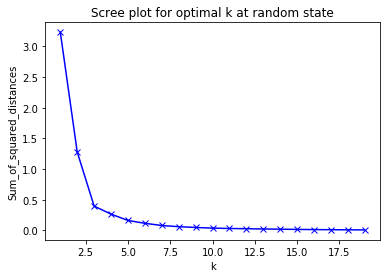

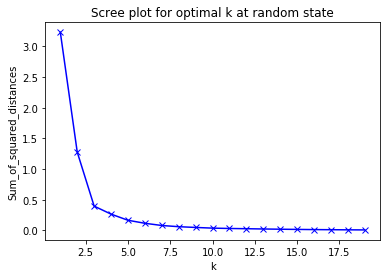

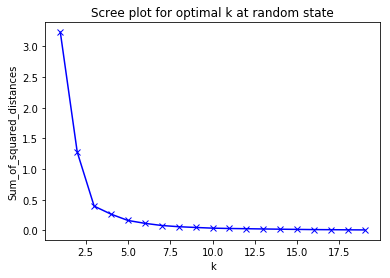

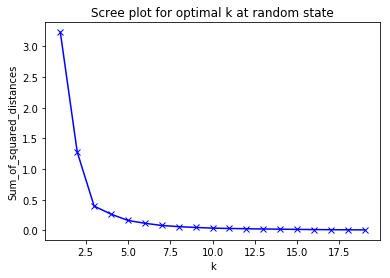

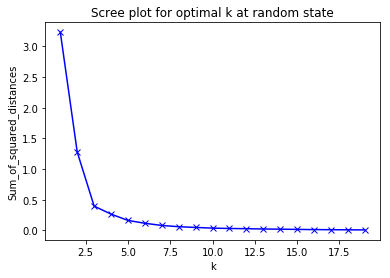

In [101]:
# No significant difference between different random initializations
for state in range(5):
    get_best_k(models[2], 20, state) #model3

In [109]:
#K means
cluster_with_k(models[2], 3)#best k according to scree plot

# H cluster
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[2], 3)



['computer_science', 'finance', 'design', 'communication', 'science', 'english', 'economics', 'accounting', 'marketing', 'business_administration', 'studies', 'technology', 'mathematics', 'information_systems']


['human_resources', 'psychology', 'political_science', 'mechanical_engineering', 'electrical_engineering', 'law', 'international_business', 'information_technology']


['management', 'business', 'engineering', 'computer']



Now with H clustering: 


['computer_science', 'finance', 'design', 'communication', 'science', 'english', 'economics', 'accounting', 'marketing', 'business_administration', 'studies', 'technology', 'mathematics', 'information_systems']


['management', 'business', 'engineering', 'computer']


['human_resources', 'psychology', 'political_science', 'mechanical_engineering', 'electrical_engineering', 'law', 'international_business', 'information_technology']




In [110]:
cluster_with_k(models[2], 5)
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[2], 5)




['finance', 'science', 'economics', 'marketing', 'technology']


['human_resources', 'psychology', 'political_science', 'law', 'international_business', 'information_technology']


['management', 'business', 'engineering', 'computer']


['computer_science', 'design', 'communication', 'english', 'accounting', 'business_administration', 'studies', 'mathematics', 'information_systems']


['mechanical_engineering', 'electrical_engineering']



Now with H clustering: 


['computer_science', 'design', 'communication', 'english', 'accounting', 'marketing', 'business_administration', 'studies', 'mathematics', 'information_systems']


['management', 'business', 'engineering', 'computer']


['human_resources', 'psychology', 'political_science', 'law', 'international_business', 'information_technology']


['finance', 'science', 'economics', 'technology']


['mechanical_engineering', 'electrical_engineering']




In [112]:
cluster_with_k(models[2], 10) 
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[2], 10)



['computer_science', 'design', 'marketing', 'studies', 'information_systems']


['computer']


['political_science', 'information_technology']


['finance', 'science', 'economics']


['communication', 'english', 'accounting', 'business_administration', 'mathematics']


['human_resources', 'psychology', 'law', 'international_business']


['mechanical_engineering', 'electrical_engineering']


['management']


['business', 'engineering']


['technology']



Now with H clustering: 


['business', 'engineering']


['communication', 'english', 'accounting', 'business_administration', 'mathematics']


['finance', 'science', 'economics']


['human_resources', 'psychology', 'law', 'international_business']


['mechanical_engineering', 'electrical_engineering']


['computer_science', 'design', 'marketing', 'studies', 'information_systems']


['management']


['political_science', 'information_technology']


['technology']


['computer']




#### Skill

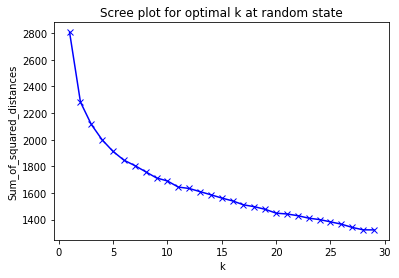

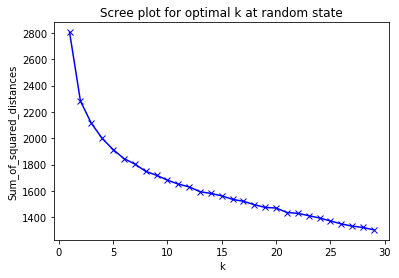

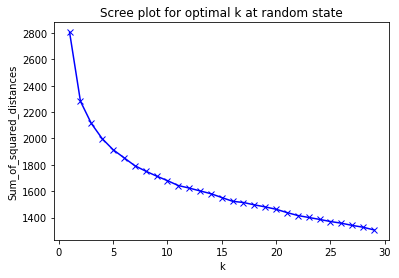

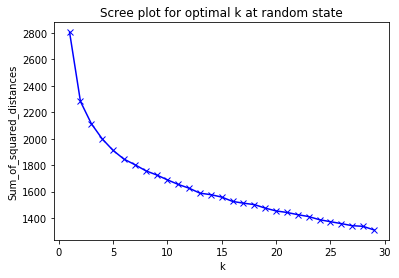

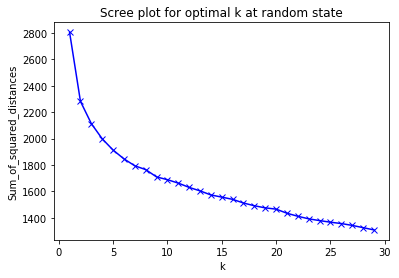

In [38]:
for state in range(5):
    get_best_k(models[1], random_state = state) #model2

In [113]:
cluster_with_k(models[1], 6)
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[1], 6)



['software_development', 'contract_negotiation', 'portfolio_management', 'procurement', 'international_sales', 'pipeline', 'integrated_marketing', 'television', 'sales_presentations', 'elearning', 'data_analysis', 'market_research', 'spss', 'public_relations', 'event_planning', 'microsoft_office', 'microsoft_excel', 'fundraising', 'web_design', 'interaction_design', 'data_warehousing', 'oracle', 'business_intelligence', 'sql', 'unix', 'requirements_gathering', 'access', 'tsql', 'performance_management', 'employment_law', 'hr_policies', 'onboarding', 'labor_relations', 'hris', 'broadcast', 'itil', 'call_center', 'telecommunication', 'iphone', 'ip', 'services', 'gas', 'vendor_management', 'troubleshooting', 'service_delivery', 'outsourcing', 'pharmaceutical', 'twitter', 'facebook', 'digital_media', 'talent_acquisition', 'interviewing', 'workforce_planning', 'team_leadership', 'professional_services', 'screening', 'lead_generation', 'process_improvement', 'loan', 'financial_reporting', 

In [114]:
cluster_with_k(models[1], 13)
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[1], 13)



['team', 'cash', 'construction', 'contract', 'brand', 'talent', 'key_account', 'clinical', 'innovation', 'energy', 'community', 'executive', 'budget', 'sales', 'retail', 'agile_project', 'software_project', 'supplier', 'information_security', 'hospitality', 'event', 'hotel', 'healthcare', 'project_portfolio', 'website', 'crisis', 'campaign', 'small_business', 'pl', 'logistics', 'human_resources', 'safety', 'web_content', 'content', 'human_capital', 'channel', 'property', 'commercial', 'sports', 'environmental', 'customer_experience', 'travel', 'restaurant', 'learning', 'asset', 'office']


['molecular_biology', 'retail_banking', 'commercial_banking', 'autocad', 'instructional_design', 'online_advertising', 'concept_development', 'information_architecture', 'corporate_identity', 'graphic_design', 'corporate_branding', 'illustrator', 'plsql', 'requirements_analysis', 'disaster_recovery', 'employee_relations', 'benefits_administration', 'hr_strategy', 'employee_engagement', 'organizatio

#### Industry

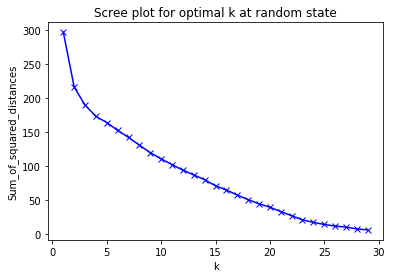

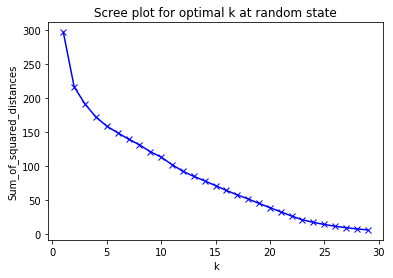

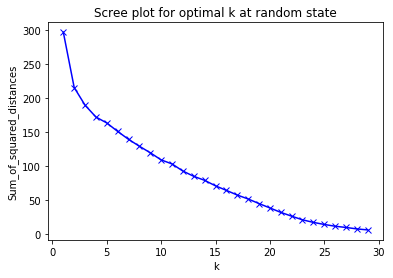

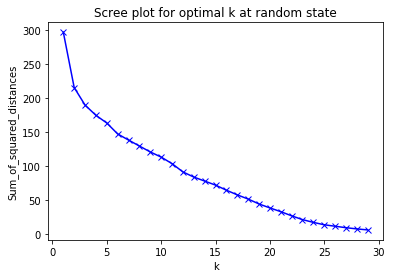

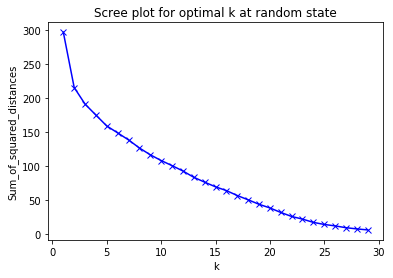

In [68]:
for state in range(5):
    get_best_k(models[5], random_state = state) #model6

In [115]:
cluster_with_k(models[5], 8)
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[5], 8)



['software', 'networking', 'games', 'hardware', 'network_security']


['insurance', 'telecommunication', 'pharmaceutical', 'accounting', 'wireless', 'internet', 'real_estate', 'medical_devices', 'hospitality', 'architecture_planning', 'defense_space', 'automotive', 'mining_metals', 'law_practice', 'apparel_fashion', 'industrial_automation', 'graphic', 'retail', 'construction', 'government_administration', 'sport', 'food_beverages', 'biotechnology', 'utility', 'semiconductor', 'chemical', 'publishing', 'entertainment', 'music', 'aviation_aerospace', 'civil_engineering']


['research', 'banking', 'oil', 'energy', 'media', 'management', 'market', 'design', 'consumer', 'human', 'resources', 'venture_capital', 'private_equity', 'computer', 'goods', 'mechanical_industrial', 'engineering', 'higher', 'leisure_travel', 'tourism', 'professional_training', 'coaching', 'electronics']


['education', 'consulting', 'investment', 'nonprofit_organization']


['hospital', 'health', 'care']


['financ

In [116]:
cluster_with_k(models[5], 10)
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[5], 10)



['insurance', 'telecommunication', 'pharmaceutical', 'accounting', 'wireless', 'internet', 'real_estate', 'medical_devices', 'hospitality', 'architecture_planning', 'defense_space', 'automotive', 'mining_metals', 'law_practice', 'apparel_fashion', 'industrial_automation', 'retail', 'construction', 'government_administration', 'sport', 'food_beverages', 'biotechnology', 'utility', 'semiconductor', 'chemical', 'publishing', 'entertainment', 'music', 'aviation_aerospace', 'civil_engineering']


['services', 'goods', 'mechanical_industrial', 'electronics']


['research', 'oil', 'financial', 'consumer', 'engineering', 'environmental', 'information', 'events', 'legal']


['venture_capital', 'private_equity', 'leisure_travel', 'tourism', 'professional_training']


['hospital', 'health', 'care']


['broadcast', 'online', 'production']


['banking', 'energy', 'market', 'design', 'human', 'resources', 'computer', 'software', 'networking', 'graphic', 'games', 'hardware', 'network_security']


[

### Occupation

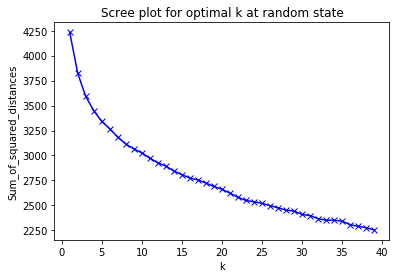

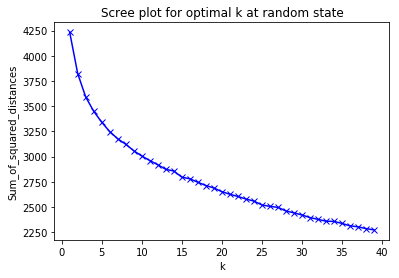

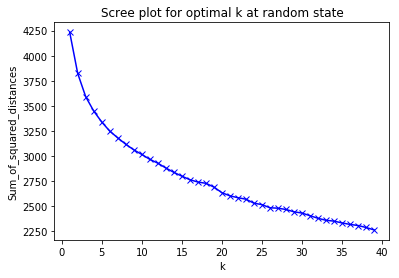

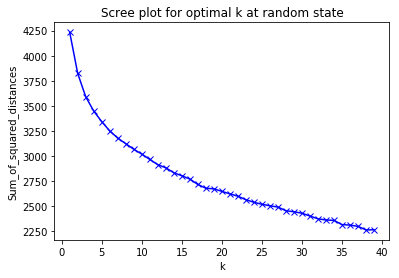

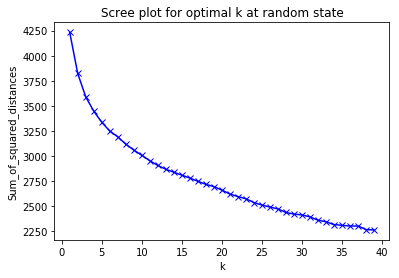

In [90]:
for state in range(5):
    get_best_k(models[0], max_k = 40, random_state = state)

In [117]:
cluster_with_k(models[0], 20)
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[0], 20)



['engineering', 'ii', 'production', 'application_development', 'technical_support', 'network', 'business_intelligence', 'project', 'technical', 'lead', 'information', 'quality', 'quality_control', 'rd', 'implementation', 'system', 'computer', 'information_security', 'principal', 'systems', 'architecture', 'software', 'research', 'mechanical', 'coop', 'technologies', 'infrastructure', 'software_development', 'materials', 'telecom', 'core', 'product_development', 'data', 'store', 'control', 'quality_assurance', 'data_management', 'ip', 'human_factors', 'crm', 'project_lead', 'electrical', 'process', 'plant', 'platform', 'manufacturing', 'program_management', 'new_product', 'electronics', 'centre', 'security', 'testing', 'software_engineering', 'solution', 'programme', 'applications', 'project_leader', 'mechanical_design', 'iii', 'application', 'test', 'wireless', 'software_test', 'qa', 'embedded_software', 'safety', 'advanced']


['international_business', 'front_desk', 'key_account', 

In [118]:
cluster_with_k(models[0], 15)# No more clusters of single item
print('\nNow with H clustering: ')
print('\n')
cluster_with_h(models[0], 15)



['director', 'head', 'division', 'group', 'vice_president', 'global', 'strategy', 'partner', 'executive', 'vp', 'svp', 'director_global', 'general_manager', 'controller', 'leader', 'managing_director', 'officer', 'summer_analyst', 'canada', 'avp', 'mgr', 'vp_sales', 'analytics', 'middle_east', 'vp_marketing', 'emea', 'consumer', 'north_america', 'americas', 'director_strategic', 'vp_global', 'country_manager', 'asia_pacific', 'asia', 'uk', 'vp_business', 'products', 'vp_product', 'apac', 'gm', 'evp', 'central', 'global_head']


['assistant_professor', 'fellow', 'professor', 'phd_candidate', 'program', 'assistant', 'library', 'department', 'student', 'lecturer', 'teaching_assistant', 'school', 'intern', 'part_time', 'graduate_research', 'instructor', 'leadership', 'asst', 'trainee', 'institute', 'graduate_student', 'research_assistant', 'placement', 'team_member', 'internship', 'graduate', 'parttime', 'teaching', 'postdoctoral_research', 'mba', 'human', 'associate_professor', 'science